# Advanced Lane Lines
## Imports and Variables


In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from moviepy.editor import VideoFileClip # needed to edit/save/watch video clips
from IPython.display import HTML

nx = 9               # the number of inside corners in x of provided chessboard
ny = 6               # the number of inside corners in y

debug = False        # set to True to enhance diagnostic messages
first_frame = True   # used to improve efficiency of sliding window searches

ym_per_pix = 30/720  # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Camera Calibration
## Utility Methods

In [2]:
## utility methods 
## starter code from https://github.com/udacity/CarND-Camera-Calibration

def calibrate():
    objp = np.zeros((ny*nx,3), np.float32) # prepare object points, like (0,0,0), (1,0,0) ...
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    images = glob.glob('camera_cal/calibration*.jpg') # glob a list from calibration images

    for idx, fname in enumerate(images):
        gray = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None) # Find chessboard corners

        if ret == True: # # If success, add points
            objpoints.append(objp)
            imgpoints.append(corners)
            
    _, mtx, dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    return mtx, dist

def corners_unwarp(img, nx, ny, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    gray = cv2.cvtColor(undist,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret == True: # corners were found
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            src = np.float32([corners[0], corners[nx-1],
                corners[len(corners[:])-nx], corners[len(corners[:])-1]])
            offset = 100; # specify an offset to map the unwarped into
            dst = np.float32([[offset,offset], [gray.shape[1]-offset,offset],
                [offset,gray.shape[0]-offset], [gray.shape[1]-offset,gray.shape[0]-offset]])
            Minv = cv2.getPerspectiveTransform(dst, src)
            M = cv2.getPerspectiveTransform(src, dst)
            warped = cv2.warpPerspective(undist, M, (img.shape[1], img.shape[0]), 
                flags=cv2.INTER_LINEAR)
    return warped, M, Minv

def carnd_camera(): # parameters for carnd videos, settings for region_of_interest
    w, h, h_clip_factor = 1280, 720, 0.50
    vertices = np.array([[(w*.04, h), (w*.45, h*h_clip_factor), (w*.54, h*h_clip_factor), (w*.96, h)]], dtype=np.int32)
    return vertices, h_clip_factor

## Validate calibration and unwarping 

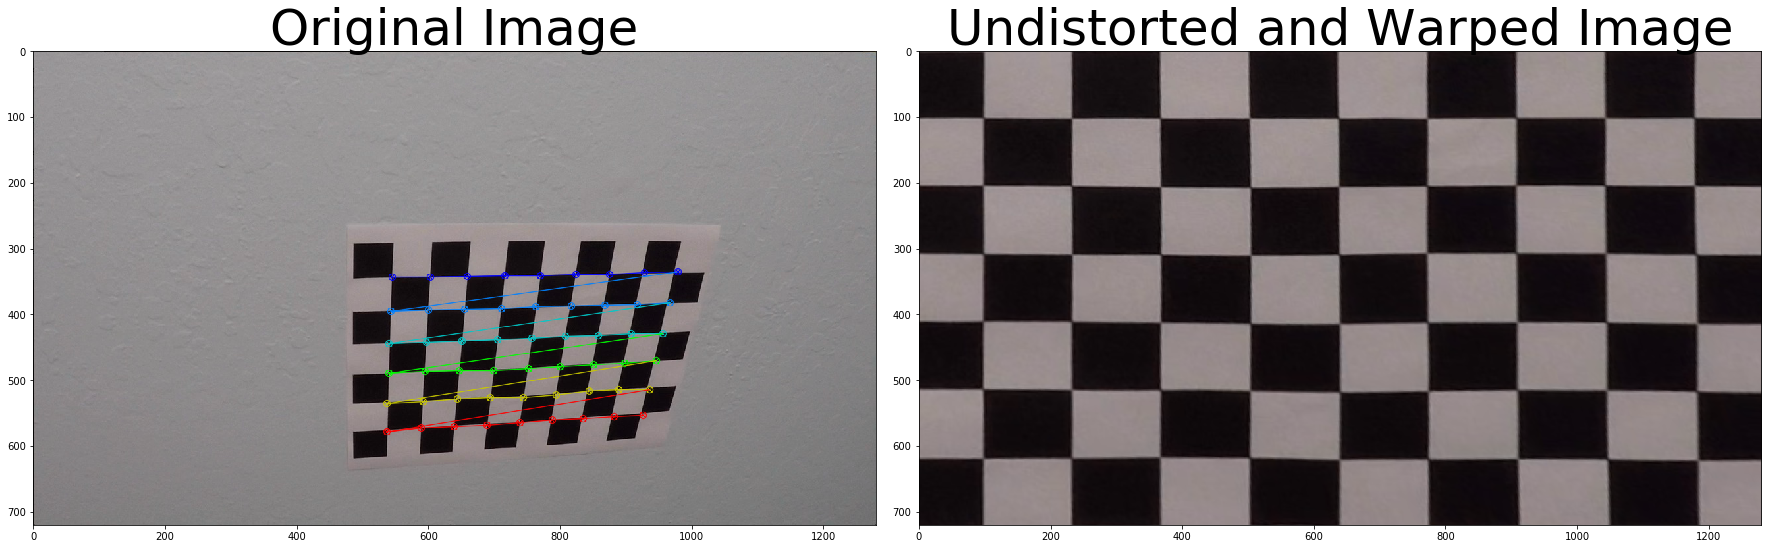

In [ ]:
mtx, dist = calibrate()

# Read in an image
img = cv2.imread('camera_cal/calibration10.jpg')

top_down, perspective_M, perspective_Minv = corners_unwarp(img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Determine Region of Interest

Superimpose multiple test images to get a good bounding box for regions of interest. This will be used later in the processing pipeline.

In [ ]:
img = cv2.imread("superimpose_region_of_interest.jpg");
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

# Create Pipeline

## Methods for Thesholding by Gradients, Magnitude, Direction and Color

In [ ]:
##### starter code from CarND module: "30. Color and Gradient module"

# Define a function that applies Sobel x and y, then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)): ## FROM "22. Magnitude of Gradient" course module
    
    # Apply the following steps to img
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)                   # 1) Convert to grayscale
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel) # 2) Take the gradient in x and y separately
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    mag = np.sqrt(sobelx*sobelx + sobely*sobely)                   # 3) Calculate the magnitude
    scaled_mag = np.uint8(255*mag/np.max(mag))                     # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    binary_output =  np.zeros_like(scaled_mag)                     # 5) Create a binary mask where mag thresholds are met
    binary_output[(scaled_mag >= mag_thresh[0]) & (scaled_mag <= mag_thresh[1])] = 1
    return binary_output                                           # 6) Return this mask as your binary_output image

# Define a function that applies Sobel x and y, then computes the direction of the gradient
# and applies a threshold.
def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)): ## from "23. Direction of the gradient" course module
    
    # Apply the following steps to img
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)                   # 1) Convert to grayscale
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel) # 2) Take the gradient in x and y separately
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)                               # 3) Take the absolute value of the x and y gradients
    abs_sobely = np.absolute(sobely)
    direction = np.arctan2(abs_sobely, abs_sobelx)                 # 4) Calculate the direction of the gradient
    binary_output = np.zeros_like(direction)                       # 5) Create a binary mask where direction thresholds are met
    binary_output[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    return binary_output                                            # 6) Return this mask as your binary_output image

def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255): ## from "21. Applying Sobel" course module
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)                     # Convert to grayscale
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))   # Apply x|y gradient with  OPenCV Sobel() function
    if orient == 'y':                                                # and take the absolute value
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))         # Rescale back to 8 bit integer
    binary_output = np.zeros_like(scaled_sobel)                      # Create a copy and apply the threshold
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output                                             # Return the result

def hls_thresh(img, h_threshold=(0,180), l_threshold=(0,255), s_threshold=(0,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    H = hls[:,:,0] ##  range is 0..180
    L = hls[:,:,1] ##  range is 0..255
    S = hls[:,:,2] ##  range is 0..255
            
    binary_output = np.zeros_like(H)
    binary_output[
        (H >= h_threshold[0]) & (H <= h_threshold[1]) &
        (S >= s_threshold[0]) & (S <= s_threshold[1]) &
        (L >= l_threshold[0]) & (L <= l_threshold[1])
    ] = 1
    return binary_output

def region_of_interest(img):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """    
    vertices, clip = carnd_camera()
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        matched_mask_color = (1.0,) * channel_count
    else:
        matched_mask_color = 1
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, matched_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = np.zeros_like(img)
    cv2.bitwise_and(src1=img, src2=mask, dst=masked_image)
    return masked_image

## Add the Pipeline

In [ ]:
"""
pipeline() processes an iput image, applying several filters and returning a binarized 
image where white pixels indicate evidence of lane lanes, and black pixels represent 
an absence of lane lines
"""
def pipeline(img, detailed=False):
    img = np.copy(img)
    
    # Sobel x,y
    gradx = abs_sobel_thresh(img, orient='x', thresh_min=20)
    grady = abs_sobel_thresh(img, orient='y', thresh_min=20)
    
    # in HLS, H 0..180, yellow = 20,30
    yellow_binary = hls_thresh(img, h_threshold=(20,35), l_threshold=(0,255), s_threshold=(0,255))
    white_binary = hls_thresh(img, h_threshold=(0,180), l_threshold=(200,255), s_threshold=(0,255))
    mag_binary = mag_thresh(img, mag_thresh=(50, 255))
    dir_binary = dir_thresh(img, thresh=(1/8 * np.pi, 3/8 * np.pi))
    
    combined = np.zeros_like(yellow_binary)  # from "24.Combining Thresholds" course module
    combined[(((yellow_binary == 1) | (white_binary == 1)))] = 1
    combined = region_of_interest(combined)
    
    if detailed:
        return gradx, grady, yellow_binary, white_binary, mag_binary, dir_binary, combined
    else:
        return combined

# Test the Pipeline

In [ ]:
image = mpimg.imread('test_images/test4.jpg')
gradx, grady, yellow_binary, white_binary, mag_binary, dir_binary, binary_result = pipeline(image, detailed=True)

f, axes = plt.subplots(4, 2, figsize=(50, 25)) # Plot the result
f.tight_layout()

axes[0,0].imshow(image)
axes[0,0].set_title('Original Image', fontsize=40)
axes[0,1].imshow(binary_result, cmap='gray')
axes[0,1].set_title('Combined Result', fontsize=40)

axes[1,0].imshow(gradx, cmap='gray')
axes[1,0].set_title('Gradient x Result', fontsize=40)
axes[1,1].imshow(grady, cmap='gray')
axes[1,1].set_title('Gradient y Result', fontsize=40)

axes[2,0].imshow(yellow_binary, cmap='gray')
axes[2,0].set_title('Yellow Binary Result', fontsize=40)
axes[2,1].imshow(white_binary, cmap='gray')
axes[2,1].set_title('White Binary Result', fontsize=40)

axes[3,0].imshow(mag_binary, cmap='gray')
axes[3,0].set_title('Magnitude Binary Result', fontsize=40)
axes[3,1].imshow(dir_binary, cmap='gray')
axes[3,1].set_title('Direction Binary Result', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=1.9, bottom=0.)

In [ ]:
"""
transform forward-facing vehicle camera image to a topdown view 
"""
def warp(img):
    shape = (img.shape[1], img.shape[0])
    if debug:
        print("transforming forward camera image to topdown view, img shape = {}".format(shape))
    from_box = np.float32([[310,681],[567,485],[788,485],[1022,681]])
    offset=np.float32([200,0])
    src = np.float32([from_box[0],from_box[1],from_box[2],from_box[3]])
    dst = np.float32([np.array([0,shape[1]]) + np.array(offset),
                      np.array([0,0.5*shape[1]]) + np.array(offset),
                      np.array([shape[0],0.5*img.shape[0]]) - np.array(offset),
                      np.array([shape[0],img.shape[0]]) - np.array(offset)
        ])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img, M, shape, flags=cv2.INTER_LINEAR)  
    return warped, M, Minv

def forwardCameraToBirdsEye(img):
    global M, Minv
    binary_result = pipeline(img, detailed=False)
    binary_warped,M,Minv = warp(cv2.undistort(binary_result, mtx, dist, None, mtx))
    return binary_warped

# Validate Perspective Transform

In [ ]:
image = mpimg.imread('test_images/test4.jpg')
img_warped, _, _ = warp(cv2.undistort(image, mtx, dist, None, mtx))
binary_warped = forwardCameraToBirdsEye(image)
                        
f, axes = plt.subplots(1, 3, figsize=(20, 9))
f.tight_layout()
axes[0].imshow(image)
axes[0].set_title('Original Image', fontsize=30)
axes[1].imshow(img_warped)
axes[1].set_title('Undistorted and\n Warped Image', fontsize=30)
axes[2].imshow(binary_warped, cmap='gray')
axes[2].set_title('Undistorted and \nWarped Binary Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=1.7, bottom=0.)

# Visual Peaks, Should be Bimodal

In [ ]:
# visualize the peaks from the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

# Detect Lane Lines
## Methods and Classes

In [ ]:
def detectLanes(binary_warped, left_lane_line, right_lane_line):
    
    global first_frame
    
    if first_frame:     
        # Take a histogram of the bottom half of the image
        ## from "33. Finding the lines" in CardND course module
        bottom_rows = binary_warped.shape[0]//2
        histogram = np.sum(binary_warped[bottom_rows:,:], axis=0)

        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        nwindows = 9 ## number of sliding windows
        window_height = np.int(binary_warped.shape[0]/nwindows)

        # Create an output image to draw on and visualize the result
        out_img = (np.dstack((binary_warped, binary_warped, binary_warped)) * 255).astype(np.uint8)

        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base

        margin = 100 ## width of the windows +/- margin
        minpix = 50  ## minimum number of pixels found to recenter window

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            if debug:
                print("{} {} {} {} {} {}".format(win_y_low, win_y_high, 
                    win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (0,255,0), 4) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (0,255,0), 4) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        first_frame = False
    else:
        # We ennter with a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        ## also from "33. Finding the lines" in CardND course module
        
        # Create an output image to draw on and visualize the result
        out_img = (np.dstack((binary_warped, binary_warped, binary_warped)) * 255).astype(np.uint8)

        left_fit = left_lane_line.current_fit;
        right_fit = right_lane_line.current_fit;
        
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
        left_fit[1]*nonzeroy + left_fit[2] + margin))) 

        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
        right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
    # persist values to R/L LaneLine objects
    left_lane_line.update(left_fitx, ploty, left_fit)
    right_lane_line.update(right_fitx, ploty, right_fit)
    
    lane_width_px = np.mean(right_fitx) - np.mean(left_fitx)
    lane_center_px = np.mean(left_fitx) + lane_width_px/2
    vehicle_dist_from_center_px = 640 - lane_center_px;
    vehicle_dist_from_center_m = vehicle_dist_from_center_px * xm_per_pix;

    return  out_img, vehicle_dist_from_center_m

In [ ]:
# class to track status
class LaneLine():
        
    def __init__(self):
        
        #radius of curvature of the line in some units
        self.radius_of_curvature = 0 
        #polynomial coefficients for the most recent fit
        self.current_fit = np.polyfit([0 ,0], [1,1], 1)
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        # last y values corresponding to the xfitted  set
        self.y = []
        # influence of prior values of radius, used in low pass filter
        self.α = 0.95; 
        
    def update(self, fitx, y, fit):
        self.xfitted = fitx;
        self.y = y;
        self.current_fit = fit;
        self.calculateCurvature(fit, fitx, y)

    def calculateCurvature(self, fit, fit_pts, y): ## starter code from "35. Measuring Curvature" course module
        # calculate radius of curvature at bottom of the screen (or, essentially, at the from bumper)
        y_max = np.max(y)
        curverad = ((1 + (2*fit[0]*y_max + fit[1])**2)**1.5) / np.absolute(2*fit[0])
        # Fit new polynomials to x,y in world space
        fit_world = np.polyfit(y*ym_per_pix, fit_pts*xm_per_pix, 2)
        # Calculate the new radii of curvature, in m
        curverad_world = ((1 + (2*fit_world[0]*y_max*ym_per_pix + fit_world[1])**2)**1.5) / np.absolute(2*fit_world[0])
        if debug:
            print("curvature = {} m",format(curverad_world))
        self.lowpass(curverad)
        return curverad_world

    # Establish a low pass filter for left and right curvatures
    def lowpass(self, latest):          ## de-emphasize transient forces
        self.radius_of_curvature = self.radius_of_curvature * (1-self.α) + latest * self.α
        return self.radius_of_curvature ## α indicates the influence level of past observations
        
        

## Detect in Single Frame, Confirm by Visualization 

In [ ]:
# also from "33. Finding the lines" in CardND course module
left_lane_line = LaneLine()
right_lane_line = LaneLine()
out_img, distance = detectLanes(binary_warped, left_lane_line, right_lane_line)

plt.imshow(out_img)
plt.plot(left_lane_line.xfitted, left_lane_line.y, color='yellow')
plt.plot(right_lane_line.xfitted, right_lane_line.y, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [ ]:
# method to siperimpose fitted lines to original image
def backPlot(image, Minv, mtx, dist, binary_warped, left, right):
    # starter code from "36. Tips and Tricks for the Project" course module
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left.xfitted, left.y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right.xfitted, right.y])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

## Validate Backplotter 

In [ ]:
result = backPlot(image, Minv, mtx, dist, binary_warped, left_lane_line, right_lane_line)
plt.imshow(result)

In [ ]:
def process_image(image):
    # NOTE: return processed image for video processing, below 
    # mtx and dist must already be set globally

    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 1
    lineType = 2
    
    binary_warped = forwardCameraToBirdsEye(image)
    out_img, distance = detectLanes(binary_warped, left_lane_line, right_lane_line)
    result = backPlot(image, Minv, mtx, dist, binary_warped, left_lane_line, right_lane_line)
    
    side = 'left' if distance >= 0 else 'right'
    t1 = "Lane Curvature Left: {0:5.0f}m Right: {1:5.0f}m". \
        format(round(left_lane_line.radius_of_curvature, 0),
               round(right_lane_line.radius_of_curvature, 0))
    t2 = "Distance {:.1f} to the {} of center".format(round(abs(distance),1), side)
    
    # minimum radius from 
    # http://onlinemanuals.txdot.gov/txdotmanuals/rdw/horizontal_alignment.htm#BGBHGEGC
    if  min(left_lane_line.radius_of_curvature, right_lane_line.radius_of_curvature) < 832:
        fontColor=(255,0,0)
    else:
        fontColor = (255,255,255)
        
    cv2.putText(result, t1, (10,50), font, fontScale, fontColor, lineType)
    cv2.putText(result, t2, (10,100), font, fontScale, fontColor, lineType)
    
    return result

In [ ]:
# unit test the processor
first_frame = True;
testImage = mpimg.imread('test_images/test4.jpg')
result = process_image(testImage)
plt.imshow(result)

# The Main Attraction!

In [ ]:
output = 'output_videos/advanced_lane_lines.mp4'
v_clip = VideoFileClip("project_video.mp4")

first_frame = True;
left_lane_line = LaneLine()
right_lane_line = LaneLine()

clip = v_clip.fl_image(process_image)
%time clip.write_videofile(output, audio=False)

HTML("""<video width="640" height="360" controls><source src="{0}"></video>""".format(output))

from rubric


Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

Methods have been used to identify lane line pixels in the rectified binary image. The left and right line have been identified and fit with a curved functional form (e.g., spine or polynomial). Example images with line pixels identified and a fit overplotted should be included in the writeup (or saved to a folder) and submitted with the project.

Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

Here the idea is to take the measurements of where the lane lines are and estimate how much the road is curving and where the vehicle is located with respect to the center of the lane. The radius of curvature may be given in meters assuming the curve of the road follows a circle. For the position of the vehicle, you may assume the camera is mounted at the center of the car and the deviation of the midpoint of the lane from the center of the image is the offset you're looking for. As with the polynomial fitting, convert from pixels to meters.

Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

The fit from the rectified image has been warped back onto the original image and plotted to identify the lane boundaries. This should demonstrate that the lane boundaries were correctly identified. An example image with lanes, curvature, and position from center should be included in the writeup (or saved to a folder) and submitted with the project.



tips 

Do your curvature values make sense?
We're not expecting anything like perfection for this project, but a good check on whether or not your perspective transform worked as expected, your conversion from pixel space to world space was correct, and that you successfully calculated the radius of curvature is whether or not your results are roughly consistent with reality.

Here is an image from Google maps of where the project video was made (just northwest of the Udacity office!). Here, I've drawn a circle to coincide with the first left curve in the project video. This is a very rough estimate, but as you can see, the radius of that circle is approximately 1 km. You don't need to tune your algorithm to report exactly a radius of 1 km in the project, but if you're reporting 10 km or 0.1 km, you know there might be something wrong with your calculations!

Here are some other tips and tricks for building a robust pipeline:

Offset
You can assume the camera is mounted at the center of the car, such that the lane center is the midpoint at the bottom of the image between the two lines you've detected. The offset of the lane center from the center of the image (converted from pixels to meters) is your distance from the center of the lane.

Tracking
After you've tuned your pipeline on test images, you'll run on a video stream, just like in the first project. In this case, however, you're going to keep track of things like where your last several detections of the lane lines were and what the curvature was, so you can properly treat new detections. To do this, it's useful to define a Line() class to keep track of all the interesting parameters you measure from frame to frame. Here's an example:

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
You can create an instance of the Line() class for the left and right lane lines to keep track of recent detections and to perform sanity checks.

Sanity Check
Ok, so your algorithm found some lines. Before moving on, you should check that the detection makes sense. To confirm that your detected lane lines are real, you might consider:

Checking that they have similar curvature
Checking that they are separated by approximately the right distance horizontally
Checking that they are roughly parallel
Look-Ahead Filter
Once you've found the lane lines in one frame of video, and you are reasonably confident they are actually the lines you are looking for, you don't need to search blindly in the next frame. You can simply search within a window around the previous detection.

For example, if you fit a polynomial, then for each y position, you have an x position that represents the lane center from the last frame. Search for the new line within +/- some margin around the old line center.

Double check the bottom of the page here to remind yourself how this works.

Then check that your new line detections makes sense (i.e. expected curvature, separation, and slope).

Reset
If your sanity checks reveal that the lane lines you've detected are problematic for some reason, you can simply assume it was a bad or difficult frame of video, retain the previous positions from the frame prior and step to the next frame to search again. If you lose the lines for several frames in a row, you should probably start searching from scratch using a histogram and sliding window, or another method, to re-establish your measurement.

Smoothing
Even when everything is working, your line detections will jump around from frame to frame a bit and it can be preferable to smooth over the last n frames of video to obtain a cleaner result. Each time you get a new high-confidence measurement, you can append it to the list of recent measurements and then take an average over n past measurements to obtain the lane position you want to draw onto the image.

Drawing
Once you have a good measurement of the line positions in warped space, it's time to project your measurement back down onto the road! Let's suppose, as in the previous example, you have a warped binary image called warped, and you have fit the lines with a polynomial and have arrays called ploty, left_fitx and right_fitx, which represent the x and y pixel values of the lines. You can then project those lines onto the original image as follows:

# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)